# Minimal RIGNO training

This notebook contains a minimal example for using RIGNO.

It only serves as a demonstration, therefore we only train a small RIGNO on one of the easiest datasets, `ACE`, which can be learnt by relatively small models and few training samples.

Fancy training strategies such as *all2all* pairing, *fractional pairing*, and *learning rate scheduling*, and *lead time scheduling* are omitted for the ease of understanding the workflow.

Let's import the necessary modules first:

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState

from rigno.dataset import Dataset
from rigno.models.operator import Inputs
from rigno.models.rigno import RIGNO, RegionInteractionGraphBuilder
from rigno.stepping import OutputStepper, ResidualStepper, TimeDerivativeStepper, AutoregressiveStepper
from rigno.plot import plot_trajectory, plot_estimates
from rigno.metrics import mse_loss, rel_lp_error_mean

We set our training settings as:

In [2]:
# RANDOM NUMBER GENERATOR SEED
SEED = 45
key = jax.random.PRNGKey(SEED)

# Number of training, validation, and test samples/trajectories
N_TRAIN = 32
N_VALID = 2
N_TEST = 16

# We don't use the all2all pairing strategy here
# Set TAU_MAX_TRAINING=10 to see results with this strategy
TAU_MAX_TRAINING = 1

# Feel free to increase the number of epochs
TRAINING_EPOCHS = 40

# Small batch sizes are slower but more effective in our experience
BATCH_SIZE = 2

# Fix learning rate
LR = 1e-04

You should first download the `ACE` or another dataset from [the Zenodo repository](https://zenodo.org/doi/10.5281/zenodo.14765453) and put it in a foloder as: `../rigno-data/unstructured/ACE.nc`.

Let's define the dataset and visualize a sample:

In [3]:
dataset = Dataset(
  datadir='../rigno-data',
  datapath='unstructured/ACE',
  time_downsample_factor=2,
  space_downsample_factor=1.5,  # per direction
  n_train=N_TRAIN,
  n_valid=N_VALID,
  n_test=N_TEST,
  preload=True,
)

sample = dataset._fetch_mode(idx=0, mode='valid', get_graphs=False)

[0.0, 1.0]


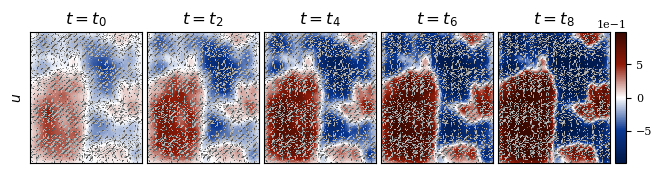

In [4]:
fig, axs = plot_trajectory(
  u=sample.u,
  x=sample.x,
  t=sample.t,
  idx_t=[0, 2, 4, 6, 8],
  idx_s=0,
  symmetric=dataset.metadata.signed['u'],
  ylabels=dataset.metadata.names['u'],
  domain=dataset.metadata.domain_x,
)

Let's create a RIGNO model and wrap it in an autoregressive time stepping strategy:

In [5]:
# Feel free to change the number of parameters as you wish
model = RIGNO(
  num_outputs=dataset.shape[-1],
  processor_steps=6,
  node_latent_size=32,
  edge_latent_size=32,
  mlp_hidden_layers=1,
  concatenate_tau=(True if dataset.time_dependent else False),
  concatenate_t=(True if dataset.time_dependent else False),
  conditioned_normalization=(True if dataset.time_dependent else False),
  cond_norm_hidden_size=16,
  p_edge_masking=0.5,
)

# Let's use the time-derivative stepper
# You can also use OutputStepper or ResidualStepper
stepper = TimeDerivativeStepper(operator=model)

# AutoregressiveStepper is a wrapper class for all time stepping strategies
autoregressive = AutoregressiveStepper(stepper=stepper, dt=dataset.dt)

Now let's define our graph builder which will be used during training:

In [6]:
# We set our graph construction settings
graph_builder = RegionInteractionGraphBuilder(
  periodic=dataset.metadata.periodic,
  rmesh_levels=4,
  subsample_factor=4,
  overlap_factor_p2r=1.0,
  overlap_factor_r2p=2.0,
  node_coordinate_freqs=4,
)

We pre-compute the graph metadata and statistics and store them in the dataset object:

In [7]:
# We use the graph builder defined above to create graph metadata
dataset.build_graphs(builder=graph_builder)

# We comptue the relevant statistics of the dataset
dataset.compute_stats(residual_steps=TAU_MAX_TRAINING)
stats = {
  key: {
    k: (jnp.array(v) if (v is not None) else None)
    for k, v in val.items()
  }
  for key, val in dataset.stats.items()
}

Now let's create some dummy inputs for the model in order to initialize it:

In [9]:
# Create dummy inputs for model initialization
dummy_graph_builder = RegionInteractionGraphBuilder(
  periodic=dataset.metadata.periodic,
  rmesh_levels=1,
  subsample_factor=4,
  overlap_factor_p2r=.01,
  overlap_factor_r2p=.01,
  node_coordinate_freqs=4,
)
dummy_graphs = dummy_graph_builder.build_graphs(
  dummy_graph_builder.build_metadata(
  x_inp=dataset.sample.x[0, 0],
  x_out=dataset.sample.x[0, 0],
  domain=np.array(dataset.metadata.domain_x),
))
dummy_graphs = jax.tree_util.tree_map(lambda v: jnp.repeat(v, repeats=BATCH_SIZE, axis=0), dummy_graphs)
dummy_inputs = Inputs(
  u=jnp.ones(shape=(BATCH_SIZE, 1, *dataset.sample.u.shape[2:])),
  c=None,
  x_inp=dataset.sample.x,
  x_out=dataset.sample.x,
  t=jnp.zeros(shape=(BATCH_SIZE, 1)),
  tau=jnp.ones(shape=(BATCH_SIZE, 1)),
)

# Initialize the model
subkey, key = jax.random.split(key)
variables = model.init(subkey, inputs=dummy_inputs, graphs=dummy_graphs)

# Report number of parameters
n_model_parameters = np.sum(
  jax.tree_util.tree_flatten(jax.tree_util.tree_map(lambda x: np.prod(x.shape).item(), variables['params']))[0]
).item()
print(f'We are going to train a RIGNO with (only) {n_model_parameters} parameters.')

We are going to train a RIGNO with (only) 90915 parameters.


In [10]:
# Set the learning rate
tx = optax.adamw(learning_rate=LR, weight_decay=1e-07)
# Create a training state
state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=tx)

Now let's train it!

If it takes long at the beginning, don't worry. JAX is compiling the codes so that the training will be faster in total.

In [ ]:
@jax.jit
def _compute_loss(params, u_inp, x_inp, t_inp, tau, u_tgt, x_out, key):
  """Computes the prediction of the model and returns its loss."""

  # Get the output
  key, subkey = jax.random.split(key)
  inputs = Inputs(
    u=u_inp,
    c=None,
    x_inp=x_inp,
    x_out=x_out,
    t=t_inp,
    tau=tau,
  )
  _loss_inputs = stepper.get_loss_inputs(
    variables={'params': params},
    stats=stats,
    u_tgt=u_tgt,
    inputs=inputs,
    graphs=graph_builder.build_graphs(batch.g),
    key=subkey,
  )

  return mse_loss(*_loss_inputs)

# Let's train a RIGNO!
init_times = jnp.arange(dataset.shape[1] - 1)
for epoch in range(TRAINING_EPOCHS):
  loss_epoch = 0

  # # NOTE: We can randomly re-build the graph so that the training is
  # # done every time with a new set of regional nodes
  # # this is necessary for achieving resolution invariance
  # dataset.build_graphs(builder=graph_builder, key=subkey)

  # Get the batches with shuffling
  subkey, key = jax.random.split(key)
  batches = dataset.batches(mode='train', batch_size=BATCH_SIZE, key=subkey)

  for i_batch, batch in enumerate(batches):
    # Get loss and updated state
    subkey, key = jax.random.split(key)

    # Pair input-outputs from the trajectories (subbatches)
    u_inp_batch = jax.vmap(
      lambda lt: jax.lax.dynamic_slice_in_dim(
        operand=batch.u,
        start_index=(lt), slice_size=1, axis=1)
    )(init_times)
    x_inp_batch = jax.vmap(
      lambda lt: jax.lax.dynamic_slice_in_dim(
        operand=batch.x,
        start_index=(lt), slice_size=1, axis=1)
    )(init_times)
    t_inp_batch = jax.vmap(
      lambda lt: jax.lax.dynamic_slice_in_dim(
        operand=batch.t,
        start_index=(lt), slice_size=1, axis=1)
    )(init_times)
    u_tgt_batch = jax.vmap(
      lambda lt: jax.lax.dynamic_slice_in_dim(
        operand=jnp.concatenate([batch.u, jnp.zeros_like(batch.u)], axis=1),
        start_index=(lt+1), slice_size=TAU_MAX_TRAINING, axis=1)
    )(init_times)
    t_tgt_batch = jax.vmap(
      lambda lt: jax.lax.dynamic_slice_in_dim(
        operand=jnp.concatenate([batch.t, jnp.zeros_like(batch.t)], axis=1),
        start_index=(lt+1), slice_size=TAU_MAX_TRAINING, axis=1)
    )(init_times)
    x_out_batch = jax.vmap(
      lambda lt: jax.lax.dynamic_slice_in_dim(
        operand=jnp.concatenate([batch.x, jnp.zeros_like(batch.x)], axis=1),
        start_index=(lt+1), slice_size=TAU_MAX_TRAINING, axis=1)
    )(init_times)
    # Repeat inputs along the time axis to match with u_tgt
    # -> [init_times, BATCH_SIZE, TAU_MAX_TRAINING, ...]
    u_inp_batch = jnp.tile(u_inp_batch, reps=(1, 1, TAU_MAX_TRAINING, 1, 1))
    x_inp_batch = jnp.tile(x_inp_batch, reps=(1, 1, TAU_MAX_TRAINING, 1, 1))
    t_inp_batch = jnp.tile(t_inp_batch, reps=(1, 1, TAU_MAX_TRAINING, 1, 1))
    # Get the lead times
    tau_batch = t_tgt_batch - t_inp_batch

    # Compute and apply gradients for each subbatch
    for i_subbatch in range(len(init_times)):
      subkey, key = jax.random.split(key)
      loss, grads = jax.value_and_grad(_compute_loss)(
        state.params, u_inp_batch[i_subbatch], x_inp_batch[i_subbatch], t_inp_batch[i_subbatch],
        tau_batch[i_subbatch], u_tgt_batch[i_subbatch], x_out_batch[i_subbatch], key=subkey
      )
      # Apply gradients
      state = state.apply_gradients(grads=grads)
      # Add to the epoch loss
      loss_epoch += loss / (len(init_times) * (N_TRAIN / BATCH_SIZE))

  # PRINT LOSS
  print(f'EPOCH {epoch:04d}/{TRAINING_EPOCHS} \t LOSS {loss:.2e}')

Alright, we have a set of parameters but no tests yet. Let's draw a big batch from the test dataset and apply the trained RIGNO on it:

In [12]:
batch = next(dataset.batches(mode='test', batch_size=N_TEST))

We can use `AutoregressiveStepper.unroll` to get a full trajectory.
Alternatively, one can use `AutoregressiveStepper.jump` to only get an estimate for a later time. This method is faster since it jumps over the unnecessary time steps.

Check the documentation of the `AutoregressiveStepper` class, it has some more cool functionalities such as different time marching strategies.

In [13]:
u_model, _ = autoregressive.unroll(
  variables={'params': state.params},  # Our trained parameters
  stats=stats,  # Dataset statistics
  num_steps=10,  # We want a trajectory of 10 time steps just like the ground-truth trajectory
  inputs=Inputs(
    u=batch.u[:, :1],  # Initial condition
    c=None,  # No known spatial parameters
    x_inp=batch.x[:, :1],  # Coordinates
    x_out=batch.x[:, :1],  # Coordinates, again
    t=batch.t[:, :1],  # Initial time
    tau=None,  # AutoregressiveStepper.unroll is based on a fixed dt, which is given to it beforehand
  ),
  graphs=graph_builder.build_graphs(batch.g),  # Build the actual graphs from the light-weight metadata
)

The first time step is the initial condition, exactly as it is given to the model:

In [14]:
assert np.allclose(u_model[:, 0], batch.u[:, 0])

Let's compute the test error on this single batch

In [15]:
# Let's check the predictions for the last time step
target_time_index = -1

# Median relative L1 test error
rel_l1_error = np.median(rel_lp_error_mean(batch.u[:, [target_time_index]], u_model[:, [target_time_index]], p=1))
print(f'Relative L1 test error (median): {rel_l1_error * 100:.2f}%')

Relative L1 test error (median): 26.47%


Now let's plot the model estimates for a single test sample:

Relative L1 test error of SAMPLE #03: 29.11%


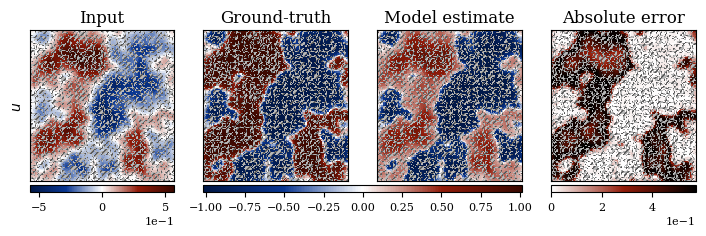

In [16]:
# Change the index to see more samples
sample_index = 3

fig = plot_estimates(
  u_inp=batch.u[sample_index, 0],
  u_gtr=batch.u[sample_index, target_time_index],
  u_prd=u_model[sample_index, target_time_index],
  x_inp=batch.x[sample_index, target_time_index],
  x_out=batch.x[sample_index, target_time_index],
  symmetric=dataset.metadata.signed['u'],
  names=dataset.metadata.names['u'],
  domain=dataset.metadata.domain_x,
)

rel_l1_error = np.median(rel_lp_error_mean(batch.u[[sample_index], [target_time_index]], u_model[[sample_index], [target_time_index]], p=1))
print(f'Relative L1 test error of SAMPLE #{sample_index:02d}: {rel_l1_error * 100:.2f}%')